<a href="https://colab.research.google.com/github/tamandakaunda-15/Formative2_HMMs/blob/main/Hidden_Markov_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Models

This project explores how machine learning can be used to recognize human activities from motion sensor data. Using accelerometer and gyroscope readings collected through the Sensor Logger app, the notebook demonstrates how to process raw signals, extract meaningful features, and train a Hidden Markov Model (HMM) that can infer hidden activity states such as walking, standing, jumping, or being still. The goal is to show how HMMs can capture temporal patterns in continuous, noisy data—making them valuable for applications like health monitoring, fall detection, and smart home activity tracking.

In [1]:
!pip install hmmlearn scikit-learn

import os
import pandas as pd
import numpy as np
import re
from scipy.stats import pearsonr
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE_PATH = '/content/drive/MyDrive/Formative_2/HMM_Project_Data_UNPROCESSED/'

print(f"\nConfiguration complete. Data will be loaded from: {DRIVE_PATH}")


Configuration complete. Data will be loaded from: /content/drive/MyDrive/Formative_2/HMM_Project_Data_UNPROCESSED/


##Feature Extraction

In [4]:
#  Feature Extraction Functions

WINDOW_SIZE_HZ = 100

def extract_features(merged_df):
    """
    Extracts 19 key features from a single merged 10-second sample.
    (Time-Domain, Magnitude, Correlation, Frequency-Domain)
    """
    features = {}

    accel_cols = ['Acc_x', 'Acc_y', 'Acc_z']
    gyro_cols = ['Gyro_x', 'Gyro_y', 'Gyro_z']
    all_cols = accel_cols + gyro_cols

    df = merged_df.copy()
    N = len(df)

    if N == 0:
        feature_names = [f'{c}_mean' for c in all_cols] + [f'{c}_std' for c in all_cols] + \
                        ['SMA', 'Acc_xy_corr', 'Acc_xz_corr', 'Acc_yz_corr'] + \
                        [f'{c}_dom_freq' for c in all_cols]
        return pd.Series(0.0, index=feature_names)

    for col in all_cols:
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_std'] = df[col].std()

    df['Acc_Mag'] = np.sqrt(df['Acc_x']**2 + df['Acc_y']**2 + df['Acc_z']**2)
    features['SMA'] = df['Acc_Mag'].abs().mean()

    try:
        features['Acc_xy_corr'] = pearsonr(df['Acc_x'], df['Acc_y'])[0]
        features['Acc_xz_corr'] = pearsonr(df['Acc_x'], df['Acc_z'])[0]
        features['Acc_yz_corr'] = pearsonr(df['Acc_y'], df['Acc_z'])[0]
    except ValueError:
        features['Acc_xy_corr'] = 0.0
        features['Acc_xz_corr'] = 0.0
        features['Acc_yz_corr'] = 0.0

    for col in all_cols:
        signal = df[col].values
        yf = fft(signal)
        power_spectrum = np.abs(yf[:N//2])**2
        xf = fftfreq(N, 1/WINDOW_SIZE_HZ)[:N//2]

        if len(power_spectrum) > 1:
            dominant_freq_index = np.argmax(power_spectrum[1:]) + 1
            features[f'{col}_dom_freq'] = xf[dominant_freq_index]
        else:
            features[f'{col}_dom_freq'] = 0.0

    return pd.Series(features)

def process_all_samples(base_dir):
    """Loads, merges, extracts features, and normalizes the entire dataset."""
    all_features = []
    all_labels = []

    activities = ['standing', 'walking', 'jumping', 'still']

    for item_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, item_name)

        if os.path.isdir(folder_path):

            name = item_name.lower()
            label = None
            for act in activities:
                match = re.search(r'^{}|[_-]{}'.format(act, act), name)
                if match:
                    label = act.capitalize()
                    break

            if label is None:
                continue

            try:
                accel_path = os.path.join(folder_path, 'Accelerometer.csv')
                gyro_path = os.path.join(folder_path, 'Gyroscope.csv')

                accel_df = pd.read_csv(accel_path).rename(columns={'x': 'Acc_x', 'y': 'Acc_y', 'z': 'Acc_z'})
                gyro_df = pd.read_csv(gyro_path).rename(columns={'x': 'Gyro_x', 'y': 'Gyro_y', 'z': 'Gyro_z'})

                merged_df = pd.merge(accel_df, gyro_df, on=['time', 'seconds_elapsed'], how='inner')

                features = extract_features(merged_df)

                all_features.append(features)
                all_labels.append(label)

            except FileNotFoundError:
                print(f"Skipping: Missing files in {item_name}")
            except Exception as e:
                print(f"Skipping: Error processing {item_name}: {e}")

    feature_matrix = pd.DataFrame(all_features)
    label_series = pd.Series(all_labels, name='Activity_Label')

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)
    normalized_df = pd.DataFrame(normalized_features, columns=feature_matrix.columns)

    return normalized_df, label_series

In [5]:
feature_matrix, activity_labels = process_all_samples(DRIVE_PATH)

print(f"Successfully processed {len(feature_matrix)} total samples.")
print("Feature Matrix Shape:", feature_matrix.shape)
print("\nActivity Distribution:")
print(activity_labels.value_counts())



Successfully processed 51 total samples.
Feature Matrix Shape: (51, 22)

Activity Distribution:
Activity_Label
Walking     16
Standing    12
Still       12
Jumping     11
Name: count, dtype: int64


## Defining Model Components

In [6]:
X_train_all = feature_matrix.values
y_train_labels = activity_labels.values

label_map = {name: i for i, name in enumerate(activity_labels.unique())}
reverse_label_map = {v: k for k, v in label_map.items()}

print(f"Training with ALL {len(X_train_all)} samples")
print(f"Number of features: {X_train_all.shape[1]}")
print(f"\nActivity distribution:")
print(activity_labels.value_counts())
print(f"\nLabel mapping: {label_map}")

Training with ALL 51 samples
Number of features: 22

Activity distribution:
Activity_Label
Walking     16
Standing    12
Still       12
Jumping     11
Name: count, dtype: int64

Label mapping: {'Jumping': 0, 'Standing': 1, 'Walking': 2, 'Still': 3}


## Building Model

In [7]:
n_states = len(label_map)
n_features = X_train_all.shape[1]

print(f"\nTraining Gaussian HMM...")
print(f"  - Hidden states: {n_states}")
print(f"  - Features: {n_features}")
print(f"  - Training samples: {len(X_train_all)}")

model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    n_iter=100,
    tol=1e-4,
    random_state=42,
    verbose=True
)

model.fit(X_train_all)

print("\n✓ Training Complete!")
print(f"  - Final log-likelihood: {model.score(X_train_all):.2f}")
print(f"  - Converged: {model.monitor_.converged}")
print(f"  - Iterations: {model.monitor_.iter}")


Training Gaussian HMM...
  - Hidden states: 4
  - Features: 22
  - Training samples: 51

✓ Training Complete!
  - Final log-likelihood: 291.52
  - Converged: True
  - Iterations: 9


         1   -1471.45110322             +nan
         2     -36.90493191   +1434.54617131
         3     277.01591126    +313.92084317
         4     284.23724339      +7.22133213
         5     285.88178685      +1.64454346
         6     289.92606578      +4.04427893
         7     291.50045447      +1.57438869
         8     291.51889804      +0.01844357
         9     291.51896277      +0.00006473


In [14]:
import seaborn as sns

Initial State Probabilities (π):
  Jumping: 1.0000
  Standing: 0.0000
  Walking: 0.0000
  Still: 0.0000


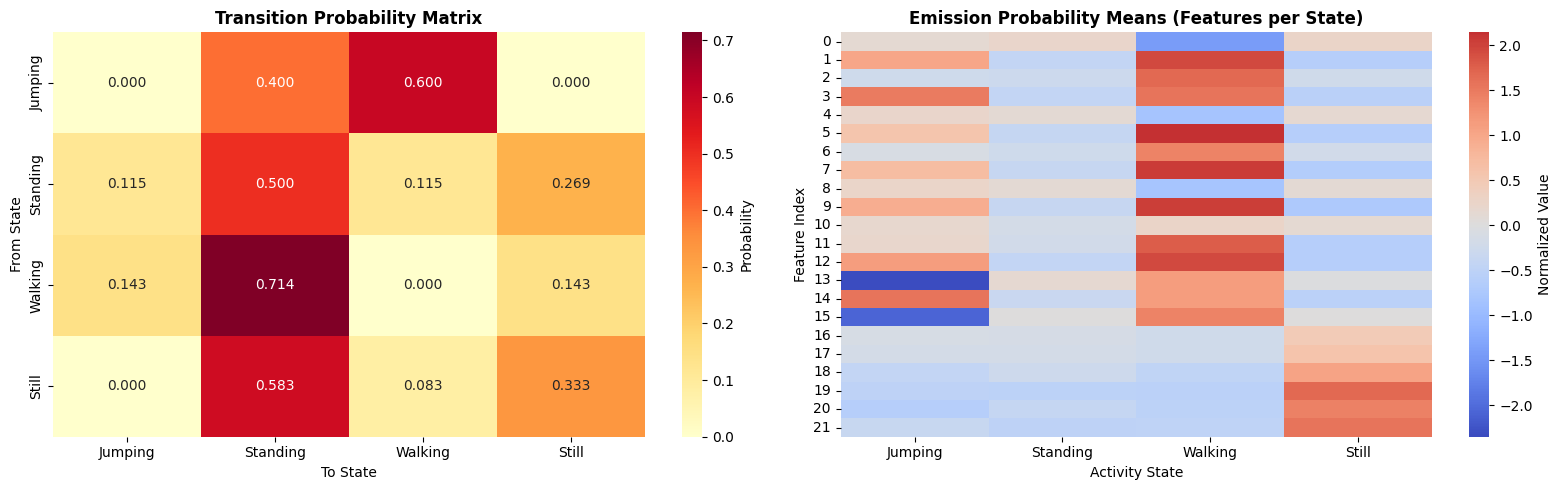

In [15]:
transition_matrix = model.transmat_
initial_probs = model.startprob_
emission_means = model.means_

print("Initial State Probabilities (π):")
for state_num, prob in enumerate(initial_probs):
    print(f"  {reverse_label_map[state_num]}: {prob:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(transition_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=list(reverse_label_map.values()),
            yticklabels=list(reverse_label_map.values()),
            ax=axes[0], cbar_kws={'label': 'Probability'})
axes[0].set_title('Transition Probability Matrix', fontweight='bold', fontsize=12)
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')

emission_df = pd.DataFrame(emission_means.T,
                           columns=list(reverse_label_map.values()))
sns.heatmap(emission_df, cmap='coolwarm', center=0, ax=axes[1],
            cbar_kws={'label': 'Normalized Value'})
axes[1].set_title('Emission Probability Means (Features per State)',
                  fontweight='bold', fontsize=12)
axes[1].set_xlabel('Activity State')
axes[1].set_ylabel('Feature Index')

plt.tight_layout()
plt.show()

Viterbi Decoding Results:
  - Log-probability: 291.52
  - Decoded 51 samples


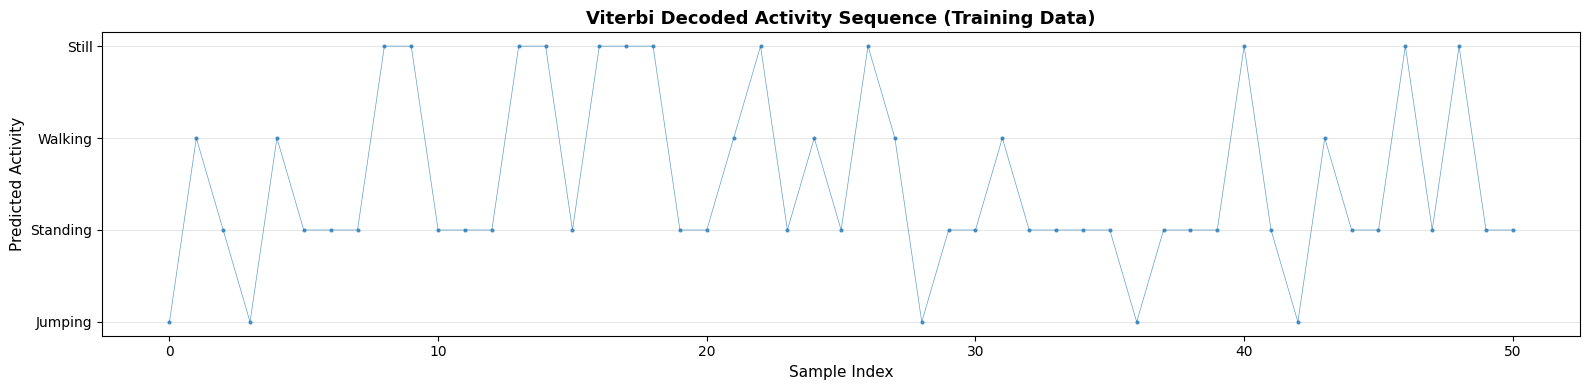

In [11]:
logprob, predicted_states = model.decode(X_train_all, algorithm='viterbi')

print(f"Viterbi Decoding Results:")
print(f"  - Log-probability: {logprob:.2f}")
print(f"  - Decoded {len(predicted_states)} samples")

plt.figure(figsize=(16, 4))
plt.plot(predicted_states, marker='o', linestyle='-', markersize=2,
         linewidth=0.5, alpha=0.7)
plt.yticks(range(n_states), list(reverse_label_map.values()))
plt.xlabel('Sample Index', fontsize=11)
plt.ylabel('Predicted Activity', fontsize=11)
plt.title('Viterbi Decoded Activity Sequence (Training Data)',
          fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Model Evaluation

In [17]:
import zipfile

def load_and_evaluate_test_data(test_folders, model, label_map, reverse_label_map):
    """
    Load new test samples, extract features, predict, and evaluate.
    """
    test_features = []
    test_labels = []

    print(f"Loading {len(test_folders)} test samples...\n")

    for folder_path, true_label in test_folders:
        try:
            accel_path = os.path.join(folder_path, 'Accelerometer.csv')
            gyro_path = os.path.join(folder_path, 'Gyroscope.csv')

            accel_df = pd.read_csv(accel_path).rename(columns={
                'x': 'Acc_x', 'y': 'Acc_y', 'z': 'Acc_z'
            })
            gyro_df = pd.read_csv(gyro_path).rename(columns={
                'x': 'Gyro_x', 'y': 'Gyro_y', 'z': 'Gyro_z'
            })

            merged_df = pd.merge(accel_df, gyro_df,
                                on=['time', 'seconds_elapsed'], how='inner')
            features = extract_features(merged_df)

            test_features.append(features)
            test_labels.append(true_label)

            print(f"✓ Loaded: {os.path.basename(folder_path)} → {true_label}")

        except Exception as e:
            print(f"✗ Error loading {folder_path}: {e}")

    if len(test_features) == 0:
        print("\n⚠ No test data loaded!")
        return None, None, None, None

    X_test = np.array(test_features)
    y_test_names = np.array(test_labels)
    y_test_num = np.array([label_map[label] for label in y_test_names])

    _, y_pred = model.decode(X_test, algorithm='viterbi')

    print(f"\n✓ Prediction complete: {len(y_pred)} samples")

    return X_test, y_test_num, y_pred, y_test_names

TEST_BASE_PATH = '/content/drive/MyDrive/Formative_2/test_data_hmm_tamanda/'
EXTRACT_PATH = '/content/test_data_extracted/'

activity_mapping = {
    'walk': 'Walking',
    'jump': 'Jumping',
    'stand': 'Standing',
    'still': 'Still'
}

os.makedirs(EXTRACT_PATH, exist_ok=True)

print("Scanning and extracting ZIP files...\n")

TEST_DATA = []

if os.path.exists(TEST_BASE_PATH):
    for file_name in sorted(os.listdir(TEST_BASE_PATH)):
        if file_name.endswith('.zip'):
            zip_path = os.path.join(TEST_BASE_PATH, file_name)

            file_lower = file_name.lower()
            detected_activity = None

            for keyword, activity_label in activity_mapping.items():
                if keyword in file_lower:
                    detected_activity = activity_label
                    break

            if detected_activity:
                extract_folder = os.path.join(EXTRACT_PATH, file_name.replace('.zip', ''))

                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_folder)

                    TEST_DATA.append((extract_folder, detected_activity))
                    print(f"  ✓ Extracted: {file_name} → {detected_activity}")

                except Exception as e:
                    print(f"  ✗ Failed to extract {file_name}: {e}")
            else:
                print(f"  ⚠ Skipped: {file_name} (no activity keyword found)")
else:
    print(f"ERROR: Path does not exist: {TEST_BASE_PATH}")

print(f"\n{'='*70}")
print(f"Total test samples prepared: {len(TEST_DATA)}")
print(f"{'='*70}\n")

if len(TEST_DATA) > 0:
    from collections import Counter
    activity_counts = Counter([label for _, label in TEST_DATA])
    print("Activity distribution:")
    for activity, count in sorted(activity_counts.items()):
        print(f"  {activity}: {count} samples")
    print()

if len(TEST_DATA) > 0:
    X_test, y_test_num, y_pred, y_test_names = load_and_evaluate_test_data(
        TEST_DATA, model, label_map, reverse_label_map
    )
else:
    print("No test data found. Please check:")
    print("  1. TEST_BASE_PATH is correct")
    print("  2. ZIP files contain 'Walk', 'Jump', 'Stand', or 'Still' in their names")

Scanning and extracting ZIP files...

  ✓ Extracted: TamJumps1-2025-10-31_13-34-03.zip → Jumping
  ✓ Extracted: TamJumps2-2025-10-31_13-34-15.zip → Jumping
  ✓ Extracted: TamJumps3-2025-10-31_13-34-30.zip → Jumping
  ✓ Extracted: TamJumps4-2025-10-31_13-34-41.zip → Jumping
  ✓ Extracted: TamStandas4-2025-10-31_13-23-10.zip → Standing
  ✓ Extracted: TamStands1-2025-10-31_13-24-17.zip → Standing
  ✓ Extracted: TamStands2-2025-10-31_13-23-56.zip → Standing
  ✓ Extracted: TamStands3-2025-10-31_13-23-21.zip → Standing
  ✓ Extracted: TamStands5-2025-10-31_13-22-59.zip → Standing
  ✓ Extracted: TamStands6-2025-10-31_13-22-47.zip → Standing
  ✓ Extracted: TamStill1-2025-10-31_13-32-42.zip → Still
  ✓ Extracted: TamStill2-2025-10-31_13-32-30.zip → Still
  ✓ Extracted: TamStill3-2025-10-31_13-32-19.zip → Still
  ✓ Extracted: TamStill4-2025-10-31_13-32-09.zip → Still
  ✓ Extracted: TamStill5-2025-10-31_13-31-59.zip → Still
  ✓ Extracted: TamWalks1-2025-10-31_13-24-30.zip → Walking
  ✓ Extracted: 

In [19]:
from sklearn.metrics import classification_report

MODEL EVALUATION ON UNSEEN DATA
State (Activity)  Number of Samples Sensitivity Specificity Overall Accuracy
         Jumping                  4      0.2500      1.0000           0.8500
        Standing                  6      1.0000      0.4286           0.6000
         Walking                  5      0.0000      1.0000           0.7500
           Still                  5      1.0000      1.0000           1.0000

OVERALL ACCURACY: 0.6000 (60.00%)


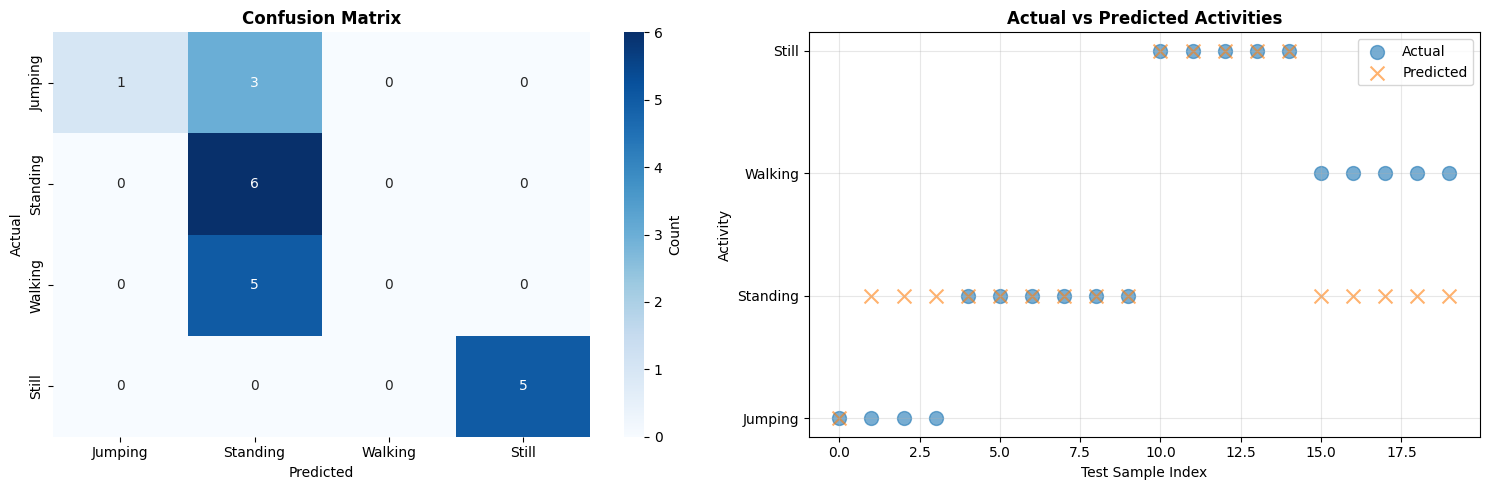


Detailed Classification Report:
              precision    recall  f1-score   support

     Jumping       1.00      0.25      0.40         4
    Standing       0.43      1.00      0.60         6
     Walking       0.00      0.00      0.00         5
       Still       1.00      1.00      1.00         5

    accuracy                           0.60        20
   macro avg       0.61      0.56      0.50        20
weighted avg       0.58      0.60      0.51        20



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
if len(TEST_DATA) > 0 and y_test_num is not None:

    cm = confusion_matrix(y_test_num, y_pred)

    metrics = []
    for i in range(n_states):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        accuracy = (TP + TN) / cm.sum()

        metrics.append({
            'State (Activity)': reverse_label_map[i],
            'Number of Samples': int(cm[i, :].sum()),
            'Sensitivity': f"{sensitivity:.4f}",
            'Specificity': f"{specificity:.4f}",
            'Overall Accuracy': f"{accuracy:.4f}"
        })

    metrics_df = pd.DataFrame(metrics)

    # Display results
    print("="*80)
    print("MODEL EVALUATION ON UNSEEN DATA")
    print("="*80)
    print(metrics_df.to_string(index=False))

    overall_acc = (y_pred == y_test_num).mean()
    print(f"\n{'='*80}")
    print(f"OVERALL ACCURACY: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
    print(f"{'='*80}")

    # Visualize confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(reverse_label_map.values()),
                yticklabels=list(reverse_label_map.values()),
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix', fontweight='bold')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Prediction visualization
    x_pos = np.arange(len(y_pred))
    axes[1].scatter(x_pos, y_test_num, label='Actual', s=100, alpha=0.6, marker='o')
    axes[1].scatter(x_pos, y_pred, label='Predicted', s=100, alpha=0.6, marker='x')
    axes[1].set_yticks(range(n_states))
    axes[1].set_yticklabels(list(reverse_label_map.values()))
    axes[1].set_xlabel('Test Sample Index')
    axes[1].set_ylabel('Activity')
    axes[1].set_title('Actual vs Predicted Activities', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_num, y_pred,
                                target_names=list(reverse_label_map.values())))
else:
    print("Configure TEST_DATA in Cell 5 to run evaluation")